An example of how one could compute the 5-sigma limiting depth for a position on the sky

In [1]:
import os
import sys

import astropy.units as u
import numpy as np
from astropy.time import Time

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.site_models.seeing_model import SeeingModel
from rubin_scheduler.utils import m5_flat_sed, SURVEY_START_MJD
import rubin_sim.skybrightness as sb

from rubin_scheduler.site_models import (
    CloudData,
    SeeingData,
    SeeingModel,
)

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# let's find the depth of a point in the sky as a function of time
band_name = "g"
band2indx = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}
band_indx = band2indx[band_name]

mjd0 = SURVEY_START_MJD # MJD
delta_t = 15.0 / 60.0 / 24.0  # time step, minutes to days
survey_length = 40.0  # Days
sun_limit = np.radians(-12.) # degrees to radians
nominal_expt = 30.0 # Seconds

# Set up position(s), here's my default spot in WFD
ras = np.radians([0.])
decs = np.radians([-20.])


In [3]:
seeing_model = SeeingModel()

seeing_indx = band_indx 
# times we want the depths at
mjds = np.arange(mjd0, mjd0 + survey_length, delta_t)

# set 
names = ["mjd", "sun_alt", "sun_n18_rising_next"]
names.append("airmass")
names.append( "sky_%s" % band_name)
names.append("m5_%s" % band_name)
names.append("fwhmEff")
names.append("clouds")

types = [float] * len(names)
result = np.zeros(mjds.size, dtype=list(zip(names, types)))
result["mjd"] = mjds




In [4]:
sm = sb.SkyModel(mags=True)
mags = []
airmasses = []
sun_alts = []

maxi = mjds.size
for i, mjd in enumerate(mjds):
    try:
        sm.set_ra_dec_mjd(ras, decs, mjd, degrees=False)
    except ValueError:
        sm.sun_alt = 12.0
    if sm.sun_alt > sun_limit:
        mags.append(sm.return_mags()[band_name] * 0)
        airmasses.append(sm.airmass * 0)
    else:
        mags.append(sm.return_mags()[band_name])
        airmasses.append(sm.airmass)
    sun_alts.append(sm.sun_alt)

mags = np.array(mags)
result["airmass"] = np.ravel(airmasses)
result["sun_alt"] = sun_alts


/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness/interp_components.py:601: UserWarning: Extrapolating twilight beyond a sun altitude of -11 degrees
  warnings.warn("Extrapolating twilight beyond a sun altitude of -11 degrees")


In [5]:
# Now to look up the seeing and cloud level
mjd_time = Time(mjd0, format="mjd")
cloud_data = CloudData(mjd_time)
seeing_data = SeeingData(mjd_time)  

In [6]:
# grab the seeing and clouds, using the same values as the baseline simulation
times = Time(mjds, format="mjd")
fwhm_500 = seeing_data(times) # Seeing at zenith and 500 nm
seeing_dict = seeing_model(fwhm_500, result["airmass"]) # Convert to our airmass and filters

# using index 1 here for g. 
result["fwhmEff"] = seeing_dict["fwhmEff"][band_indx, :]
result["clouds"] = cloud_data(times)

In [7]:
result["m5_%s" % band_name] = m5_flat_sed(band_name, np.ravel(mags), result["fwhmEff"],
                             nominal_expt, result["airmass"], nexp=1)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/m5_flat_sed.py:150: RuntimeWarning: divide by zero encountered in divide
  + 2.5 * np.log10(0.7 / fwhm_eff)


Text(0, 0.5, 'Cloud level ')

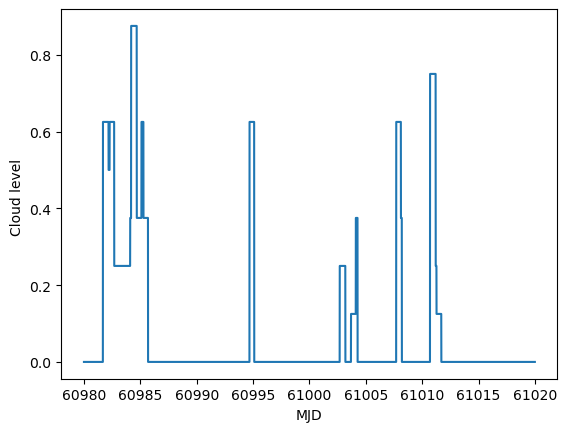

In [8]:
fig, ax = plt.subplots()

ax.plot(result["mjd"], result["clouds"])
ax.set_xlabel("MJD")
ax.set_ylabel("Cloud level ")

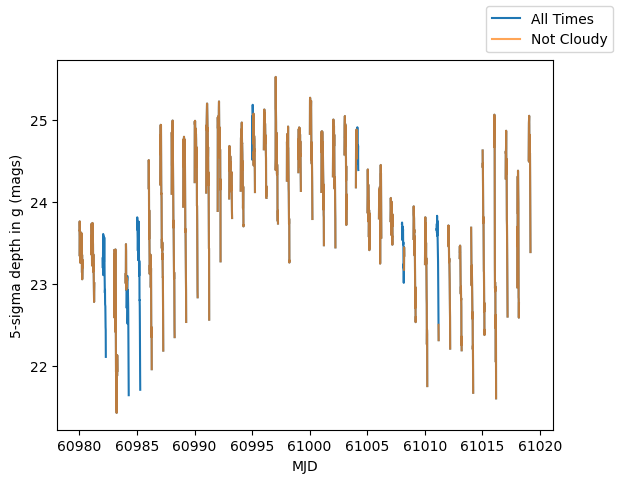

In [9]:
fig, ax = plt.subplots()

ax.plot(result["mjd"], result["m5_g"], label="All Times")

ax.set_xlabel("MJD")
ax.set_ylabel("5-sigma depth in g (mags)")

# if we remove the cloudy times
good = np.where(result["clouds"] < 0.3)[0]

ax.plot(result["mjd"][good], result["m5_g"][good], alpha=0.7, label="Not Cloudy")
leg = fig.legend()
